# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [719]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### 1) Importer le tableau de données dans un dataframe 

In [720]:
# Import du dataframe "data.csv"
df = pd.read_csv("data.csv", decimal=",", dtype = {"Enterprise": "str","Metier": "str","Technologies": "str", 
                                                   "Diplome" : "str","Experience"  : "float", "Ville" : "str"})
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [721]:
print("Nombre d'observations dans le dataset: ",df.shape[0])
print("Nombre des valeurs manquantes pour chanque variable:")
print(df.isnull().sum())
print("Nombre total des valeurs manquantes: ", df.isnull().sum().sum())

Nombre d'observations dans le dataset:  9582
Nombre des valeurs manquantes pour chanque variable:
Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64
Nombre total des valeurs manquantes:  130


### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [722]:
# calculer la valeur median de la variable Experience pour data scientists
median_experience_datascientist = df.Experience[df.Metier == "Data scientist"].median()
print("Experience: valeur médiane pour les data scientists = ",median_experience_datascientist)

# calculer la valeur moyenne de la variable Experience pour data engineers
mean_experience_dataengineer = df.Experience[df.Metier == "Data engineer"].mean()
# approximation à deux chiffres pour simplicité
mean_experience_dataengineer = round(mean_experience_dataengineer, 2)
print("Experience: valeur moyenne pour les data engineers = ", mean_experience_dataengineer)

# Imputation de valeur médiane pour Experience si metier est data scientist
df.loc[ (df['Metier'] == "Data scientist") & (df['Experience'].isna()), 'Experience'] = median_experience_datascientist
# Imputation de valeur moyenne pour Experience si metier est data engineer
df.loc[ (df['Metier'] == "Data engineer") & (df['Experience'].isna()), 'Experience'] = mean_experience_dataengineer


Experience: valeur médiane pour les data scientists =  2.0
Experience: valeur moyenne pour les data engineers =  2.98


### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [723]:
mean_experience_pour_metier = round(df.groupby("Metier")["Experience"].mean(),2)
print("Moyenne d'années d'expériences pour chaque", mean_experience_pour_metier)

Moyenne d'années d'expériences pour chaque Metier
Data architecte        3.00
Data engineer          2.98
Data scientist         2.24
Lead data scientist    3.97
Name: Experience, dtype: float64


### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

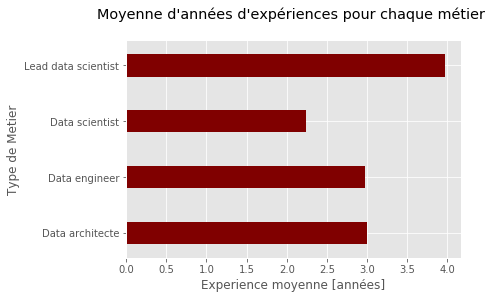

In [724]:
# histogramme à barres
plt.style.use('ggplot')
mean_experience_pour_metier.plot.barh(title = "Moyenne d'années d'expériences pour chaque métier \n", 
                                      legend = False, color ='maroon', width = 0.4)
plt.ylabel("Type de Metier")
plt.xlabel("Experience moyenne [années]")
plt.show()

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation. 

Pour répondre à cette question je vais faire une petite étude sur le données et leur distribution.
La première hypothèse est que la variable ‘Experience’ n’inclut pas les années des formations et donc il n’a pas une corrélation avec le diplôme obtenu. On peut le vérifier avec un histogramme qui montre l’expérience moyenne en fonction du diplôme. 
Les profils sans diplôme ont plus années d’expérience si comparé avec les docteurs : ça peut être justifié par le fait que les personnes qui n’ont pas étudié ont commencé plus tôt à travailler et ont obtenu plus années total de travail si comparé à des profils qui ont dédié des années à la formation. On décide quand même de donner de valeur au diplôma et l’inclure dans la variable ‘Exp_label’ en cette manière :
-	Créer une variable numérique à partir des années d’expérience
-	Ajouter 3 années si le diplôme est un PhD : le doctorat est une vraie expérience professionnelle   
-	Ajouter 0.5 années d’expérience si le diplôme est un Master : normalement à la fin d’un Master il y a un stage qui donne approx 6 mois d’expérience professionnelle 
-	Ajouter 0.25 années d’expérience si le diplôme est un Bachelor : normalement à la fin d’un Bachelor il y a un stage qui donne approx 3 mois d’expérience professionnelle 


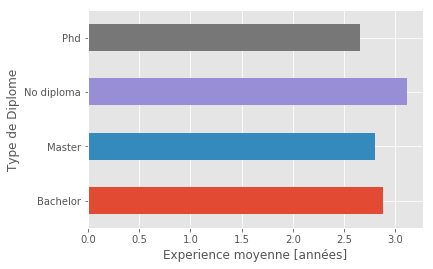

In [725]:
# Illustration graphique de l'experience moyenne en function du diplome obtenu
mean_experience_pour_diplome = df.groupby(["Diplome"])["Experience"].mean()
mean_experience_pour_diplome.plot(kind='barh',x='Diplome',y='Experience', legend=False)
plt.ylabel("Type de Diplome")
plt.xlabel("Experience moyenne [années]")
plt.show()

In [726]:
# creation d'une nouvelle variable ou ajouter années dependant du diplome
df['Exp_adjust'] = df['Experience']
df["Exp_adjust"] = np.where(df["Diplome"] == 'Phd' ,      df["Exp_adjust"] + 3,    df["Exp_adjust"])
df["Exp_adjust"] = np.where(df["Diplome"] == 'Master' ,   df["Exp_adjust"] + 0.5,  df["Exp_adjust"])
df["Exp_adjust"] = np.where(df["Diplome"] == 'Bachelor' , df["Exp_adjust"] + 0.25, df["Exp_adjust"])
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_adjust
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,1.5
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,3.5
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,3.5
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,2.0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,5.0


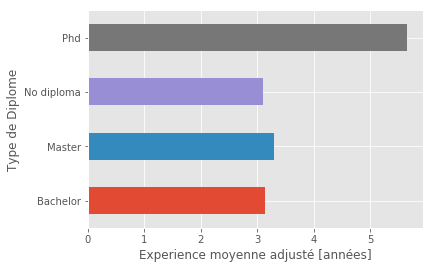

In [727]:
# apres modification
mean_experience_pour_diplome = df.groupby(["Diplome"])["Exp_adjust"].mean()
mean_experience_pour_diplome.plot(kind='barh',x='Diplome',y='Exp_adjust', legend=False )
plt.ylabel("Type de Diplome")
plt.xlabel("Experience moyenne adjusté [années]")
plt.show()

On peut maintenant établir un critère pour définir des valeurs en termes de nombre d’années, utilisant la nouvelle variable ‘Exp_adjust’, pour séparer les populations : {débutant, confirmé, avancé, expert}. Avec l'aide graphique d'un histogram avec Nombre de profils en fonction de la variable Exp_adjust, on suppose que pour les metiers Data scientist, Data engineer et Data achitecte:
-	Le 15% avec plus d’années d’expérience sont ‘experts’
-	Le quantile entre 65% et 85% son ‘avancés’
-	Le quantile entre 25% et 65% sont ‘confirmés’
-	Le 25% avec moins années d’expérience sont ‘débutants’


Pour le métier ‘Lead data scientist’, étant une rôle plus de leadership, on suppose que il n’y a pas de débutants mais seulement {confirmé: 0-20%, avancé 20-65%, expert 65-100%}.


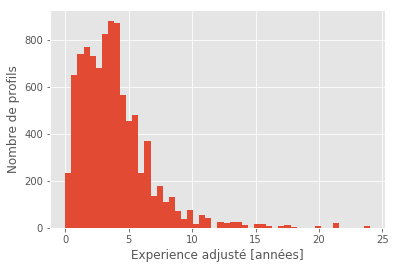

In [728]:
# Histogram pour avoir une visione graphique de la distribution
plt.hist(df[~df['Exp_adjust'].isnull()].Exp_adjust, bins=50, range=(0, df.Exp_adjust.max()))
#plt.hist(df.Exp_adjust, bins=50, range=(0, df.Exp_adjust.max()))
plt.ylabel("Nombre de profils")
plt.xlabel("Experience adjusté [années]")
plt.show()

In [729]:
# divisions: differentes pour chaque metier

df["Exp_label"] = "debutant"
# quantiles Data scientist
p85_DS = df[df['Metier'] == 'Data scientist'].Exp_adjust.quantile(0.85)
p65_DS = df[df['Metier'] == 'Data scientist'].Exp_adjust.quantile(0.65)
p25_DS = df[df['Metier'] == 'Data scientist'].Exp_adjust.quantile(0.25)

# assignation variable
df.loc[(df.Exp_adjust >= p25_DS ) & (df['Metier'] == 'Data scientist'), "Exp_label"]  = "confirme"
df.loc[(df.Exp_adjust >= p65_DS ) & (df['Metier'] == 'Data scientist'), "Exp_label"]  = "avance"
df.loc[(df.Exp_adjust >= p85_DS ) & (df['Metier'] == 'Data scientist'), "Exp_label"]  = "expert"

# quantiles Data engineer
p85_DE = df[df['Metier'] == 'Data engineer'].Exp_adjust.quantile(0.85)
p65_DE = df[df['Metier'] == 'Data engineer'].Exp_adjust.quantile(0.65)
p25_DE = df[df['Metier'] == 'Data engineer'].Exp_adjust.quantile(0.25)
# assignation variable
df.loc[(df.Exp_adjust >= p25_DE ) & (df['Metier'] == 'Data engineer'), "Exp_label"]  = "confirme"
df.loc[(df.Exp_adjust >= p65_DE ) & (df['Metier'] == 'Data engineer'), "Exp_label"]  = "avance"
df.loc[(df.Exp_adjust >= p85_DE ) & (df['Metier'] == 'Data engineer'), "Exp_label"]  = "expert"

# quantiles Data architecte
p85_DA = df[df['Metier'] == 'Data architecte'].Exp_adjust.quantile(0.85)
p65_DA = df[df['Metier'] == 'Data architecte'].Exp_adjust.quantile(0.65)
p25_DA = df[df['Metier'] == 'Data architecte'].Exp_adjust.quantile(0.25)
# assignation variable
df.loc[(df.Exp_adjust >= p25_DA ) & (df['Metier'] == 'Data architecte'), "Exp_label"]  = "confirme"
df.loc[(df.Exp_adjust >= p65_DA ) & (df['Metier'] == 'Data architecte'), "Exp_label"]  = "avance"
df.loc[(df.Exp_adjust >= p85_DA ) & (df['Metier'] == 'Data architecte'), "Exp_label"]  = "expert"

# quantiles Lead data scientist
p65_LDS = df[df['Metier'] == 'Lead data scientist'].Exp_adjust.quantile(0.65)
p20_LDS = df[df['Metier'] == 'Lead ata scientist'].Exp_adjust.quantile(0.20)

# assignation variable
df.loc[(df["Metier"] == 'Lead data scientist'), "Exp_label"]  = "confirme"
df.loc[(df.Exp_adjust >= p20_LDS ) & (df['Metier'] == 'Lead data scientist'), "Exp_label"]  = "avance"
df.loc[(df.Exp_adjust >= p65_LDS ) & (df['Metier'] == 'Lead data scientist'), "Exp_label"]  = "expert"

print(df.Exp_label.value_counts())
df.head()

confirme    3928
expert      1934
avance      1874
debutant    1846
Name: Exp_label, dtype: int64


,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_adjust,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris,1.5,debutant
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille,3.5,confirme
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes,3.5,confirme
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille,2.0,confirme
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.0,Bordeaux,5.0,avance


### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [730]:
# creation d'une list qui contiens les 5 technologies les plus utilisées
technologies = []
for i,row in df.iterrows():
    tech = row["Technologies"].split("/")
    technologies += tech
# creation d'une serie 
series_tech = pd.Series(technologies)
# evaluation de 5 elements les plus frequents 
top5 = series_tech.value_counts()[0:5]

print("Les 5 technologies les plus uilisées sont:", )
for index, val in top5.iteritems():
       print (index, val)

Les 5 technologies les plus uilisées sont:
Python 6627
R 4374
SQL 2581
Java 1719
Hadoop 1589


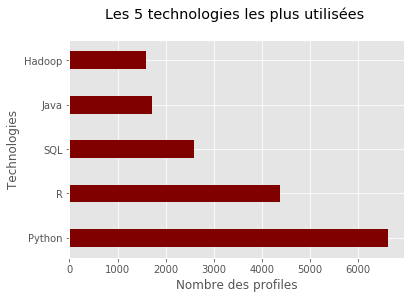

In [731]:
# Illustration graphique
top5.plot.barh(title = "Les 5 technologies les plus utilisées \n", 
               legend = False, color ='maroon', width = 0.4)
plt.ylabel('Technologies')
plt.xlabel('Nombre des profiles')
plt.show()

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

### Data pre-processing
#### Selecion variables
Avant d’introduire le modelé de clustering il faut construire un dataframe contenant les features pour la classification. Vu que l’objectif de cet exercice est de déterminer le métier d’un candidat à partir des informations sur ses compétences j’ai décidé de sélectionner et utiliser seulement les variables qui donnent une information pertinente sur les profils métiers à regrouper. Par conséquente j’ai décidé d’exclure la variable « Ville » et la variable « Entreprise » : la première parce que il n’y a pas raison de croire que les profils considérés sont liés à une position géographique specifique, en tous cas toutes les majeures villes de France sont inclues dans la liste. Egalement les data scientist, architectes et engineers peuvent exercer le travail dans entreprises très différentes : en plus la variable « Entreprise » compte un nombre très haut d’exemples (1383) différentes qui peut apporter de la complexité à l’algorithme sans, à mon avis, un pouvoir discriminante significatif.  

In [732]:
# liste de villes
villes = []
for i,row in df.iterrows():
    if row["Ville"] not in villes:
        villes.append(row["Ville"])    
print("List des villes de France:", villes)

List des villes de France: ['Paris', 'Marseille', 'Nantes', 'Bordeaux', 'Lille', 'Toulouse', 'Rouen', 'Lyon', 'Strasbourg', 'Grenoble', 'Nice', 'Toulon', 'Montpellier', 'Rennes']


In [733]:
# calculer combien d'entreprises sont considerés
entreprises = []
for i,row in df.iterrows():
    if row["Entreprise"] not in entreprises:
        entreprises.append(row["Entreprise"])    
print("Nombre des entreprises considerées:", len(entreprises))

Nombre des entreprises considerées: 1383


#### Traitement des variables selectionnées

#### TECHNOLOGIE
Pour la variable Technologie on voit qu’il y a 61 types de technologie différentes. Vu que chaque exemple peut présenter capabilité dans différentes technologies on estime que réduire la dimensionnalité de la variable Technologie pourrait aider à simplifier et rendre plus vite l’implémentation de l’algorithme sans impacter les informations disponibles : plus précisément on peut évaluer quelles sont les technologies plus populaires, on calcule que si on rétien seulement le 20 technologie plus populaire approx 95% des individus ont au moins une de ces 20 technologies. 

In [734]:
# trouver le 20 technologies plus populaires
top20 = series_tech.value_counts()[0:20]
top20 = top20.index.values.tolist()
print("List avec les 20 technologies les plus uilisées:", )
print(top20)

# evaluer le percentage des individus  qui ont au moins une de ces 20 technologies
num=0
for i,row in df.iterrows():
    tech = row["Technologies"].split("/")
    common_tech= len(np.intersect1d(top20,tech))
    if common_tech > 1:
        num = num+1

print("Percentage des individus avec au moins une de 20 technologie les plus utilisées: ", 
      round( np.array(num).sum()/len(df),2)*100, "%")


List avec les 20 technologies les plus uilisées:
['Python', 'R', 'SQL', 'Java', 'Hadoop', 'Excel', 'C++', 'Spark', 'Linux', 'MongoDB', 'VBA', 'machine learning', 'SAS', 'Docker', 'Matlab', 'Hive', 'Tensorflow', 'Elasticsearch', 'Big data', 'C']
Percentage des individus avec au moins une de 20 technologie les plus utilisées:  95.0 %


 Construir une dataframe avec les technologies selectionnées.

In [735]:
# creation du dataframe qui contient le technologies
df_technologies = pd.DataFrame(columns = top20)

for i,row in df.iterrows():
    tech = row["Technologies"].split("/")
    intersection = np.intersect1d(top20,tech)
    solution = (np.in1d(top20, intersection)).astype(int)
    df_technologies = df_technologies.append(dict(zip(df_technologies.columns, solution)), ignore_index=True)
    
df_technologies = df_technologies.astype(int)
df_technologies.head()

,Python,R,SQL,Java,Hadoop,Excel,C++,Spark,Linux,MongoDB,VBA,machine learning,SAS,Docker,Matlab,Hive,Tensorflow,Elasticsearch,Big data,C
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0


#### EXPERIENCE ET DIPLOME
Les deux variables donnent une information sur le niveau d’expérience et le dégrée du diplôme : on veut garder pour ces deux variables des nombres qui donnent une idée de l’ordre. Pour la variable ‘Experience’ on a déjà construit une autre variable ‘Exp_label’ avec 4 niveaux croissantes : cette variable tient compte soit du diplôme soit de la distribution des profils avec différents niveau d’expérience (elle était construite avec une division en quantiles). On décide d’utiliser quand même la variable diplôme pour avoir plus d’informations dans l’algorithme de clustering et pour mieux voir si le diplôme a une influence directe sur les deux clusters finals. 
Pour les deux variables catégoriques on assigne un nombre croissant entre 0 et 1 pour mantenir l'echelle :
-	Phd : 4/4, Master : 3/4, Bachelor : 2/4, No diploma : 1/4
-	Expert:4/4, Avancé: 3/4, Comfirmé: 2/4, Debutant: 1/4


In [736]:
# new dataframe avec experience
exp_map = {"debutant":1/4, "confirme":2/4, "avance":3/4, "expert":4/4}
df_exp_label = df[["Exp_label"]].replace(exp_map)
df_exp_label.head()

,Exp_label
0,0.25
1,0.50
2,0.50
3,0.50
4,0.75


In [737]:
# new dataframe avec diplome
dipl_map = {"No diploma":1/4, "Bachelor":2/4, "Master":3/4, "Phd":4/4}
df_diplome = df[["Diplome"]].replace(dipl_map)
df_diplome.head()

,Diplome
0,0.75
1,0.75
2,0.75
3,0.75
4,1.00


#### METIER
Faire une simple conversion des metiers en variables binaires.

In [738]:
# new dataframe avec metiers
df_metier = pd.get_dummies(df[["Metier"]])
df_metier.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist
0,0,0,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


Mettre tout ensemble dans un dataframe pour le clustering.

In [739]:
df_to_sum = (df_metier, df_diplome, df_exp_label, df_technologies)
df_clustering = pd.concat(df_to_sum, axis = 1)
df_clustering.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome,Exp_label,Python,R,SQL,Java,...,VBA,machine learning,SAS,Docker,Matlab,Hive,Tensorflow,Elasticsearch,Big data,C
0,0,0,1,0,0.75,0.25,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,1,0,0,0,0.75,0.50,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0.75,0.50,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0.75,0.50,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,1.00,0.75,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


### Clustering
J’ai décidé d’implémenter une simple version de kmeans avec K=2 et méthode pour initialisation: ‘k-means++’. Les autres paramètres sont laissés comme default.

In [740]:
# implementation de kmeans from sklearn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(df_clustering)
# liste de labels du cluster apres fit
predicted_clusters = kmeans.fit_predict(df_clustering)

In [741]:
# centroids
centroids = kmeans.cluster_centers_

from scipy.spatial import distance_matrix

# matrix avec disances de centroids
dist_mat = pd.DataFrame(distance_matrix(df_clustering.values, centroids))
# distance moyenne de centroids
print("Columns: centroid number. Rows: mean distance of the points in a cluster.")
dist_mat.groupby(predicted_clusters).mean()



Columns: centroid number. Rows: mean distance of the points in a cluster.


,0,1
0,1.557151,2.269348
1,2.287915,1.568973


In [742]:
# ajouter label du cluster au dataframe avec nouvelle colonne
df_clustering['Cluster'] = pd.Series(predicted_clusters, index=df.index)
df_clustering.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome,Exp_label,Python,R,SQL,Java,...,machine learning,SAS,Docker,Matlab,Hive,Tensorflow,Elasticsearch,Big data,C,Cluster
0,0,0,1,0,0.75,0.25,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
1,1,0,0,0,0.75,0.50,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0.75,0.50,1,1,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,1,0,0.75,0.50,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
4,0,0,1,0,1.00,0.75,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1


#### Résultats et interprétation
On peut calculer pour chaque variable combien d’exemples sont attribué au cluster 1 or cluster 0 et évaluer la puissance discriminante des variables différentes.

In [743]:
# dataframe avec valeur moyenne des variables dans chanque cluster
kmeans_mean_cluster = pd.DataFrame(round(df_clustering.groupby('Cluster').mean(),3))
kmeans_mean_cluster.head()

,Metier_Data architecte,Metier_Data engineer,Metier_Data scientist,Metier_Lead data scientist,Diplome,Exp_label,Python,R,SQL,Java,...,VBA,machine learning,SAS,Docker,Matlab,Hive,Tensorflow,Elasticsearch,Big data,C
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.472,0.521,0.000,0.005,0.642,0.590,0.496,0.000,0.106,0.329,...,0.000,0.000,0.000,0.206,0.000,0.145,0.000,0.184,0.000,0.070
1,0.000,0.000,0.761,0.237,0.793,0.612,0.865,0.861,0.414,0.047,...,0.197,0.196,0.186,0.000,0.171,0.042,0.167,0.000,0.162,0.083


On obtient que le premier cluster contient Data engineer et Data achitecht presque exclusivement. Le deuxième cluster contient tous les Data scientist et la majorité de Lead data scientist. Le niveau de diplôme et expérience n’ont pas un fort pouvoir discriminant mais les valeurs sont légèrement plus hauts dans la catégorie contenant les data scientist, ça est probablement dû au fait qu’il n’y a pas de débutants parmi les Lead data scientists. Python, R et SQL aussi que machine learning sont plus utilisé dans le cluster de Data scientist ; l’autre cluster préfère Java et Hadoop. 

In [744]:
from collections import Counter
print("La classe 0 contient ", Counter(kmeans.labels_)[0], " profils")
print("La classe 1 contient ", Counter(kmeans.labels_)[1], " profils")

La classe 0 contient  4501  profils
La classe 1 contient  5081  profils


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat. 

Avec le but de prédire les métiers manquants on utilise l’algorithme de classification Random Forest. La division entre training set et test set est de 70%-30%. On décide d’utiliser les mêmes variables qu’on a traités pour Kmeans : les 20 technologies les plus populaires, le diplôme et le niveau d’expérience.

In [745]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [746]:
# Processing des données 
df_to_sum = (df[["Metier"]], df_diplome, df_exp_label, df_technologies)
df_all = pd.concat(df_to_sum, axis = 1)

# Remove NaN dans 'Metier' et conversion en int
df_totrain = df_all.loc[~df['Metier'].isnull()]
map_metier = {"Data architecte":0, "Data engineer":1, "Data scientist":2, "Lead data scientist":3}
df_Y = df_totrain[["Metier"]].replace(map_metier).astype(int)
df_X = df_totrain.drop(['Metier'], axis=1)


# NaN Metiers à predire
df_topredict = df_all.loc[df['Metier'].isnull()]
df_Y_topredict = df_topredict.drop(['Metier'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y.squeeze(), test_size = 0.3, random_state = 0)

In [747]:
# Choice du modèle et entraînement
logisiticmodel = LogisticRegression(solver = "newton-cg", multi_class = "multinomial")

# Random Forest Classifier
RFC = RandomForestClassifier()
RFC.fit(X_train, Y_train)

RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [748]:
# Métriques performances
RFC.score(X_test,Y_test)
predictions = RFC.predict(X_test)
score = RFC.score(X_test, Y_test)

print("Resultats du modele: Accuracy = ", 100*round(score,2), "%")

Resultats du modele: Accuracy =  85.0 %


#### Résultats du modelé
On obtient une bonne accuracy globalement, ajouter plus technologies pourrait ameliorer les resultats. 
On observe que le modelé n’arrive pas à distinguer parfaitement les métiers de Data architecte et Data engineer : plusieurs technologies sont communes entre les deux profils et aussi les autres variables ne sont pas très discriminantes. La même chose est observée entre Data scientist et Lead data scientist : les deux profils sont très similaires, la discrimination vient du niveaux d’expérience.

In [749]:
# visualisation des resultats avec confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, predictions)
confusion_matrix_df = pd.DataFrame(data = confusion_matrix,
                                   columns = code_meanings,
                                   index = code_meanings)
confusion_matrix_df

,Data architecte,Data engineer,Data scientist,Lead data scientist
Data architecte,539,75,10,0
Data engineer,32,676,0,0
Data scientist,3,0,1067,96
Lead data scientist,1,0,201,169


La variable plus discriminante est la technologie R : il n’y a pas de Data engineers et Data achitectes qui utilisent cette technologie. Le niveau d’expérience est aussi discriminante pour distinguer Data scientist de Lead data scientist.

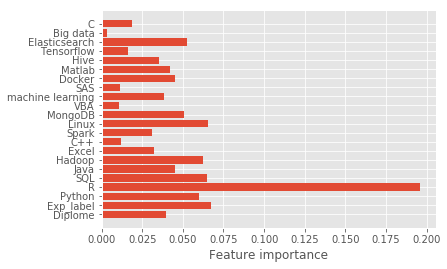

In [750]:
# feature importance
RFC.feature_importances_
plt.barh(df_X.columns, RFC.feature_importances_)
plt.xlabel("Feature importance")
plt.show()

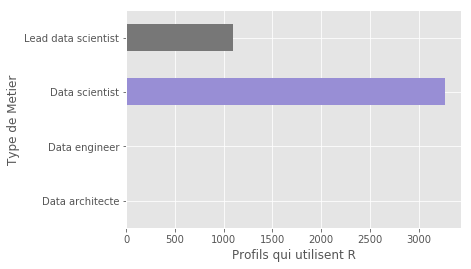

In [751]:
# Metiers regoupés by technologie R
df_R = df_totrain.groupby(["Metier"])["R"].sum()
df_R.head()
df_R.plot(kind='barh',x='Metier',y='R', legend=False )
plt.ylabel("Type de Metier")
plt.xlabel("Profils qui utilisent R")
plt.show()

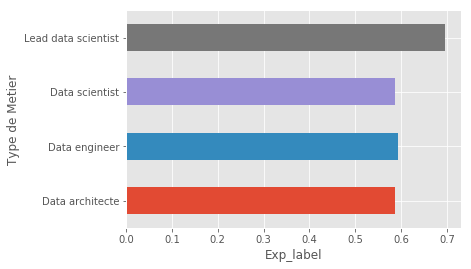

In [752]:
# Metiers regoupés by Exp_label
df_Exp_label = df_totrain.groupby(["Metier"])["Exp_label"].mean()
df_Exp_label.head()
df_Exp_label.plot(kind='barh',x='Metier',y='Exp_label', legend=False )
plt.ylabel("Type de Metier")
plt.xlabel("Exp_label")
plt.show()